## Is it a shark or a whale?

In [1]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
import os

!pip install -U duckduckgo_search
!pip install fastai
!pip install fastbook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.5 MB/s eta 0:00:00


## Step 1: Download images of sharks and whales

In [3]:
from fastbook import *
from fastai.vision.widgets import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(search_images_ddg(term, max_images=max_images))

In [4]:
searches = 'dog','cat'
path = Path('dog_or_not')
from time import sleep
from fastai.vision.all import *


for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'hungry {o} photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'cute {o} photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'dog photo'
Searching for 'hungry dog photo'
Searching for 'cute dog photo'
Searching for 'cat photo'
Searching for 'hungry cat photo'
Searching for 'cute cat photo'


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [5]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

3

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


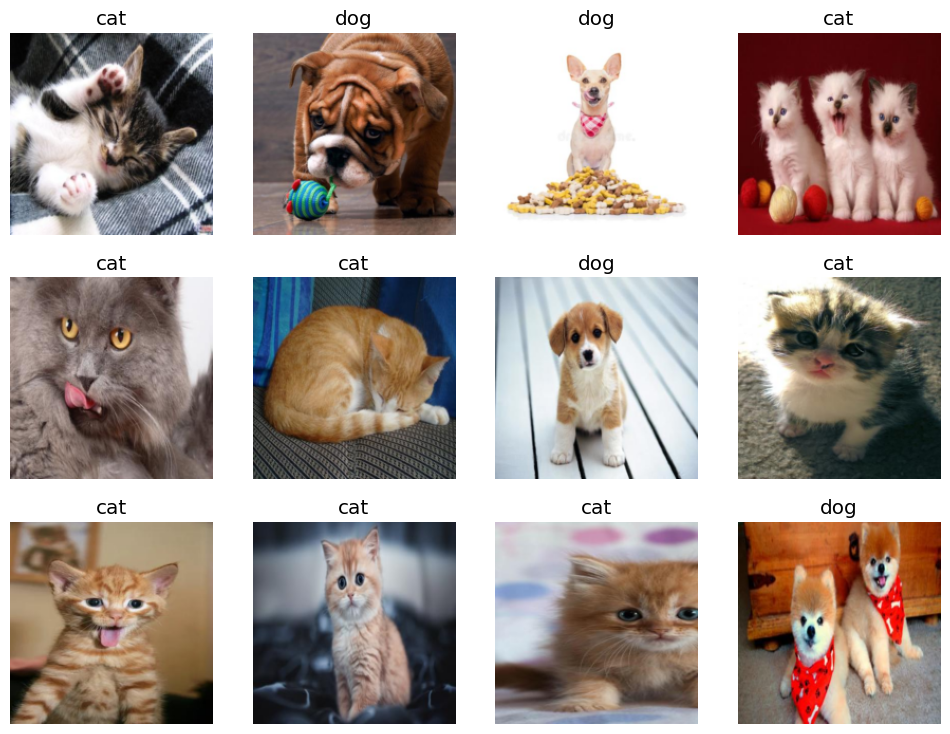

In [6]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=12)

In [7]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 118MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.686439,0.502250,0.181818,00:21


epoch,train_loss,valid_loss,error_rate,time
0,0.234744,0.265348,0.090909,00:27
1,0.131610,0.224406,0.060606,00:27
2,0.092367,0.214728,0.060606,00:27


## Clean data

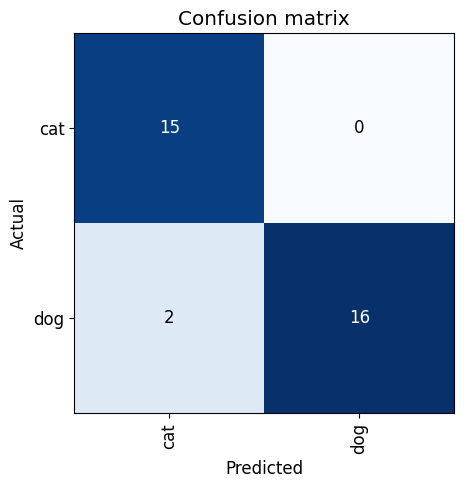

In [8]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


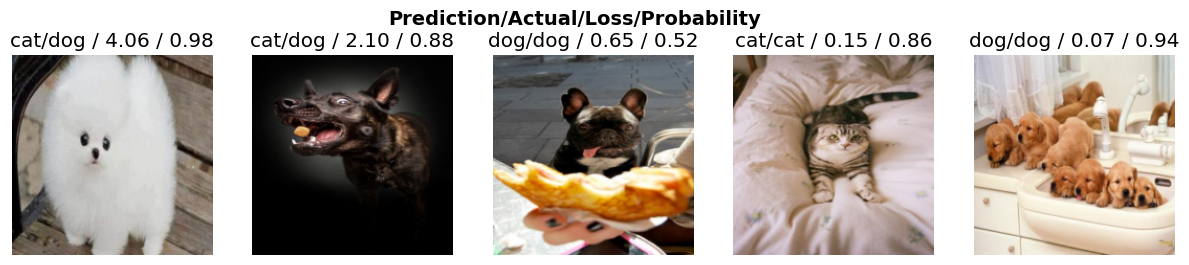

In [9]:
interp.plot_top_losses(5, nrows=1)

In [10]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

In [11]:
# #hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Step 3: Export our model

In [12]:
learn.export('model.pkl')